In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# model_name = "EmbeddingAndCNNModel"
model_name = "EmbeddingAnd2dCNNModel"
# model_name = "ResNet50"
# target_feature = "endianness"
target_feature = "instructionwidth_type"

In [2]:
# Specify the directory containing the CSV files
directory = "../../results/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "*.csv"))
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Filter on model and target feature
df = df[
    (df["model.name"] == model_name) & (df["target_feature"] == target_feature)
].reset_index(drop=True)

In [3]:
# Compute mean and std of overall accuracy
df_overall = df[df["Name"] == "overall_metrics"][["overall_accuracy"]]
overall_mean = df_overall["overall_accuracy"].mean()
overall_std = df_overall["overall_accuracy"].std()

# Remove unnecessary columns
df_filtered = df[["Name", "test_accuracy", "test_loss", "train_loss"]]

# Remove aggregation rows and rename columns
df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
    columns={"Name": "architecture"}
)

df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

df_folds.head()

,architecture,test_accuracy,test_loss,train_loss
1,x32,0.992337,0.046901,0.014946
2,sparc64,0.950855,0.479571,0.015300
3,sparc,0.998996,0.001366,0.015582
4,sh4,1.000000,0.000016,0.014562
5,s390x,1.000000,0.000108,0.015133


In [4]:
df_agg = (
    df_folds.groupby("architecture")
    .agg({"test_accuracy": ["mean", "std"]})
    .sort_values(("test_accuracy", "mean"), ascending=False)
    .reset_index()
)

df_agg

architecture test_accuracy          
                         mean       std
0       powerpc      1.000000  0.000000
1       ppc64el      1.000000  0.000000
2    powerpcspe      0.999970  0.000122
3         s390x      0.999884  0.000347
4         sparc      0.999161  0.001622
5           x32      0.998972  0.001908
6        mipsel      0.998302  0.002309
7         amd64      0.997117  0.002783
8      mips64el      0.996480  0.006601
9          s390      0.996446  0.006090
10         i386      0.996385  0.005161
11        armel      0.992574  0.009114
12        alpha      0.986816  0.023374
13        armhf      0.975307  0.021636
14         mips      0.968616  0.054247
15      sparc64      0.952165  0.020351
16          sh4      0.814294  0.302338
17        ppc64      0.810365  0.214533
18         hppa      0.661527  0.212233
19      riscv64      0.635771  0.339739
20         ia64      0.583750  0.439074
21        arm64      0.539313  0.327583
22         m68k      0.040816  0.088600

| Architecture | Mean Accuracy | Standard Deviation |
|--------------|--------------:|--------:|
| powerpc | 1.000 | 0.000 |
| ppc64el | 1.000 | 0.000 |
| powerpcspe | 1.000 | 0.000 |
| s390x | 1.000 | 0.000 |
| sparc | 0.999 | 0.002 |
| x32 | 0.999 | 0.002 |
| mipsel | 0.998 | 0.002 |
| amd64 | 0.997 | 0.003 |
| mips64el | 0.996 | 0.007 |
| s390 | 0.996 | 0.006 |
| i386 | 0.996 | 0.005 |
| armel | 0.993 | 0.009 |
| alpha | 0.987 | 0.023 |
| armhf | 0.975 | 0.022 |
| mips | 0.969 | 0.054 |
| sparc64 | 0.952 | 0.020 |
| sh4 | 0.814 | 0.302 |
| ppc64 | 0.810 | 0.215 |
| hppa | 0.662 | 0.212 |
| riscv64 | 0.636 | 0.340 |
| ia64 | 0.584 | 0.439 |
| arm64 | 0.539 | 0.328 |
| m68k | 0.041 | 0.089 |
| **Overall** | **0.861** | **0.041** |


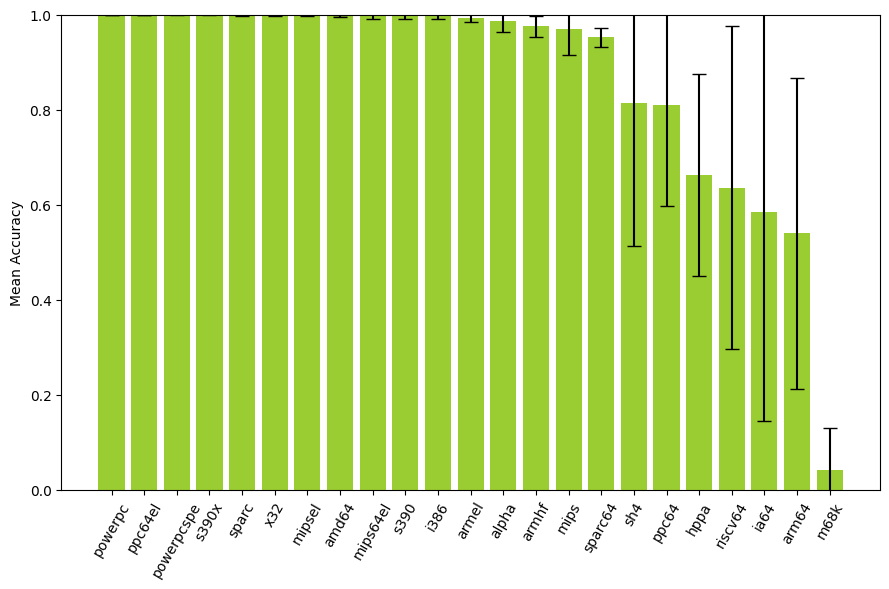

In [5]:
means = df_agg[("test_accuracy", "mean")].values
stds = df_agg[("test_accuracy", "std")].values
architectures = df_agg["architecture"].values

# Create markdown table header
print("| Architecture | Mean Accuracy | Standard Deviation |")
print("|--------------|--------------:|--------:|")

# Print each architecture's stats in table format
for arch, mean, std in zip(architectures, means, stds):
    print(f"| {arch} | {mean:.3f} | {std:.3f} |")

# Print overall accuracy and std as last row in table
print(f"| **Overall** | **{overall_mean:.3f}** | **{overall_std:.3f}** |")


plt.figure(figsize=(9, 6))
bars = plt.bar(
    range(len(architectures)), means, yerr=stds, capsize=5, color="yellowgreen"
)

# # Add value labels at the bottom of each bar with improved styling
# for bar in bars:
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width() / 2.0,
#         0.01,
#         f"{height:.2f}",
#         ha="center",
#         va="bottom",
#         rotation=0,
#         color="black",
#         fontsize=8,
#         fontweight="bold",
#         bbox=dict(
#             facecolor="white",
#             edgecolor="gray",
#             boxstyle="round,pad=0.2",
#             linewidth=0.5,
#             alpha=0.9,
#         ),
#     )

plt.xticks(range(len(architectures)), architectures, rotation=60)
# plt.title(f"Overall accuracy: {overall_mean:.3f} ± {overall_std:.3f}")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)

plt.tight_layout()